In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import datetime
import os
import time
import xarray as xr
from dateutil.relativedelta import relativedelta

from torch.utils.data import DataLoader

from utils import normalize

from mod_moving_mnist import ModMovingMNIST
from mpnnlstm import NextFramePredictorAR, NextFramePredictorS2S
from model import MPNNLSTMI, MPNNLSTM
from seq2seq import Seq2Seq
from ice_test import IceDataset

/Users/zach/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/zach/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
coarsen = 0

ds = xr.open_zarr('data/era5_hb_daily.zarr')

if coarsen != 0:
    ds = ds.coarsen(latitude=coarsen, longitude=coarsen, boundary='trim').mean()
    
mask = np.isnan(ds.siconc.isel(time=0)).values

In [3]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Number of frames to read as input
input_timesteps = 5
output_timesteps= 30

x_vars = ['siconc', 't2m', 'v10', 'u10', 'sshf']
y_vars = ['siconc']  # ['siconc', 't2m']
training_years = range(2015, 2016)

input_features = len(x_vars)

month = 6

data_train = IceDataset(ds, training_years, month, input_timesteps, output_timesteps, x_vars, y_vars, train=False)
data_test = IceDataset(ds, [training_years[-1]+1], month, input_timesteps, output_timesteps, x_vars, y_vars)
data_val = IceDataset(ds, [training_years[-1]+2], month, input_timesteps, output_timesteps, x_vars, y_vars)

loader_train = DataLoader(data_train, batch_size=1, shuffle=True)
loader_test = DataLoader(data_test, batch_size=1, shuffle=True)
loader_val = DataLoader(data_val, batch_size=1, shuffle=False)

In [11]:
input_features = len(x_vars)
thresh = 0.35

def dist_from_05(arr):
    return abs(abs(arr - 0.5) - 0.5)

# Add 3 to the number of input features since we add positional encoding (x, y) and node size (s)
model_kwargs = dict(
    hidden_size=64,
    dropout=0.1,
    n_layers=3,
    transform_func=dist_from_05
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('mps')
print('device:', device)


model = NextFramePredictorS2S(
    thresh=thresh,
    experiment_name=str(month)+'test',
    input_features=input_features,
    output_timesteps=output_timesteps,
    transform_func=dist_from_05,
    device=device,
    model_kwargs=model_kwargs)

model.model

device: cpu


Seq2Seq(
  (encoder): Encoder(
    (rnns): ModuleList(
      (0): GConvLSTM(
        (conv_x_i): GCNConv(8, 64)
        (conv_h_i): GCNConv(64, 64)
        (conv_x_f): GCNConv(8, 64)
        (conv_h_f): GCNConv(64, 64)
        (conv_x_c): GCNConv(8, 64)
        (conv_h_c): GCNConv(64, 64)
        (conv_x_o): GCNConv(8, 64)
        (conv_h_o): GCNConv(64, 64)
      )
      (1): GConvLSTM(
        (conv_x_i): GCNConv(64, 64)
        (conv_h_i): GCNConv(64, 64)
        (conv_x_f): GCNConv(64, 64)
        (conv_h_f): GCNConv(64, 64)
        (conv_x_c): GCNConv(64, 64)
        (conv_h_c): GCNConv(64, 64)
        (conv_x_o): GCNConv(64, 64)
        (conv_h_o): GCNConv(64, 64)
      )
      (2): GConvLSTM(
        (conv_x_i): GCNConv(64, 64)
        (conv_h_i): GCNConv(64, 64)
        (conv_x_f): GCNConv(64, 64)
        (conv_h_f): GCNConv(64, 64)
        (conv_x_c): GCNConv(64, 64)
        (conv_h_c): GCNConv(64, 64)
        (conv_x_o): GCNConv(64, 64)
        (conv_h_o): GCNConv(64, 64)
   

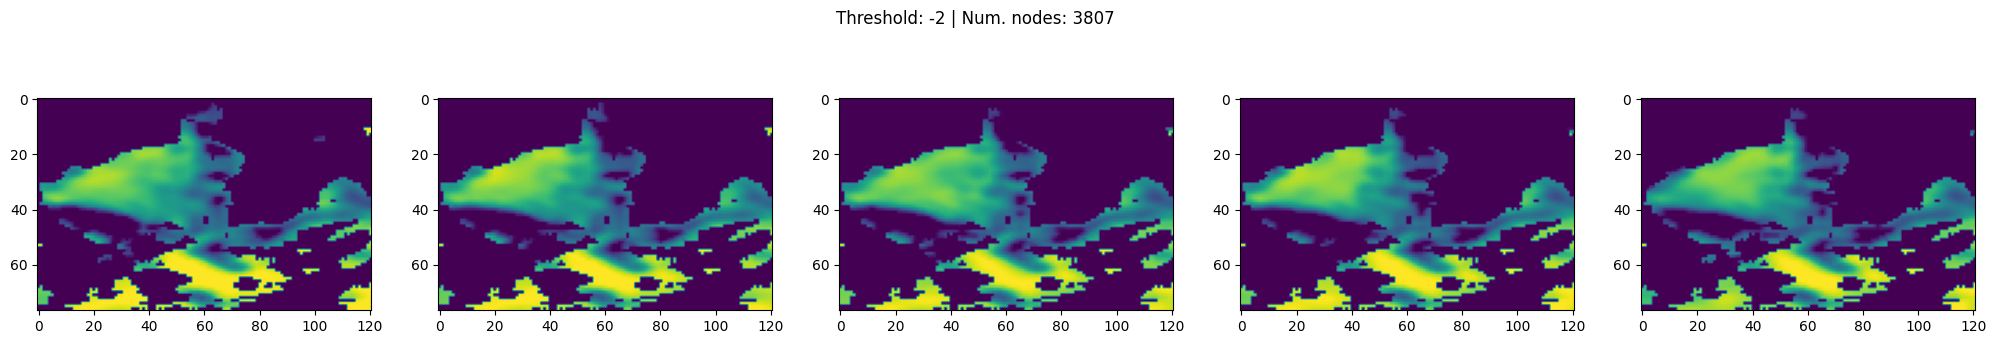

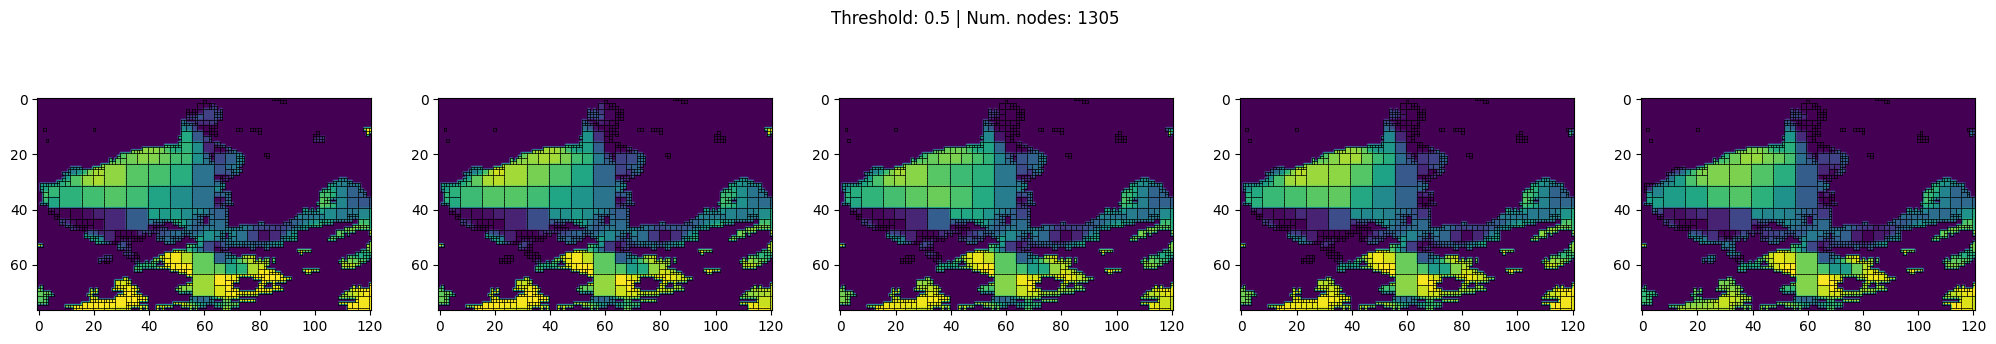

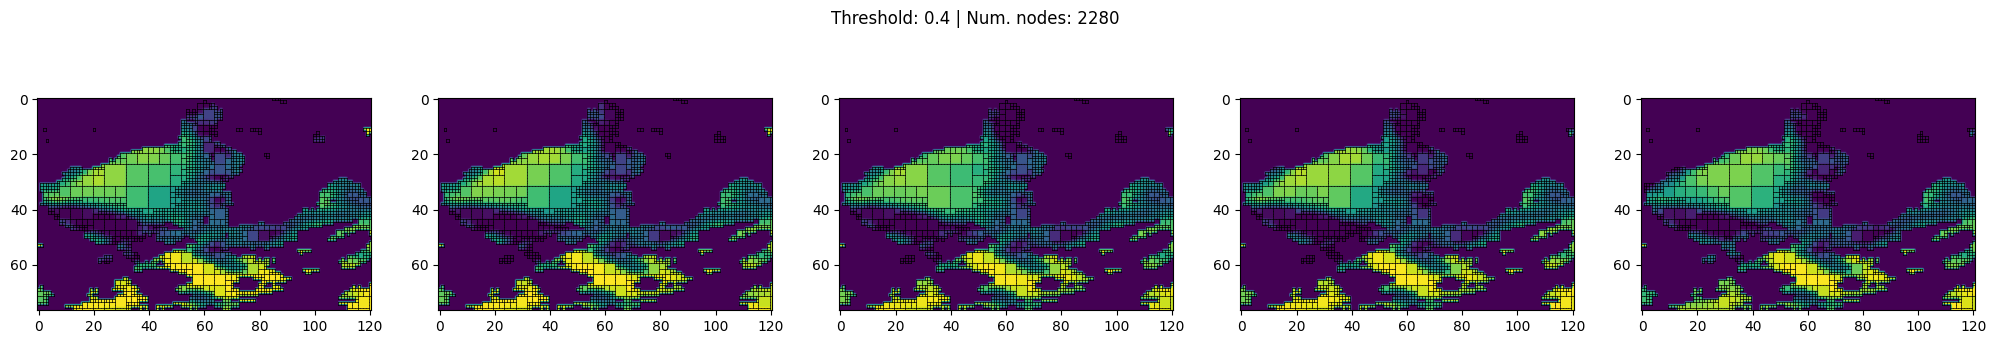

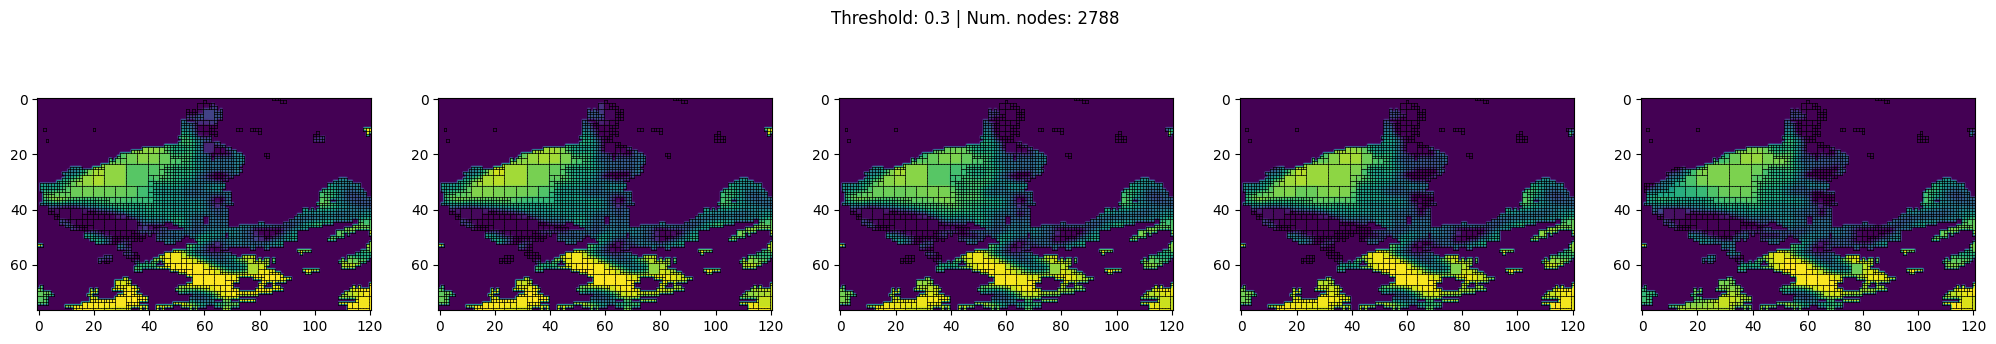

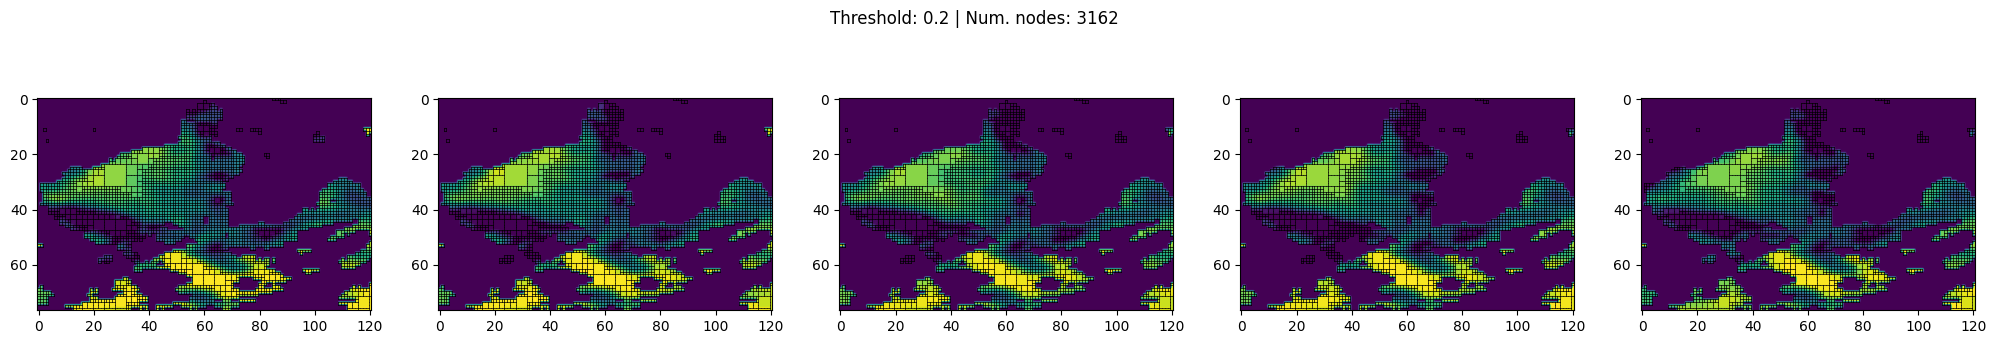

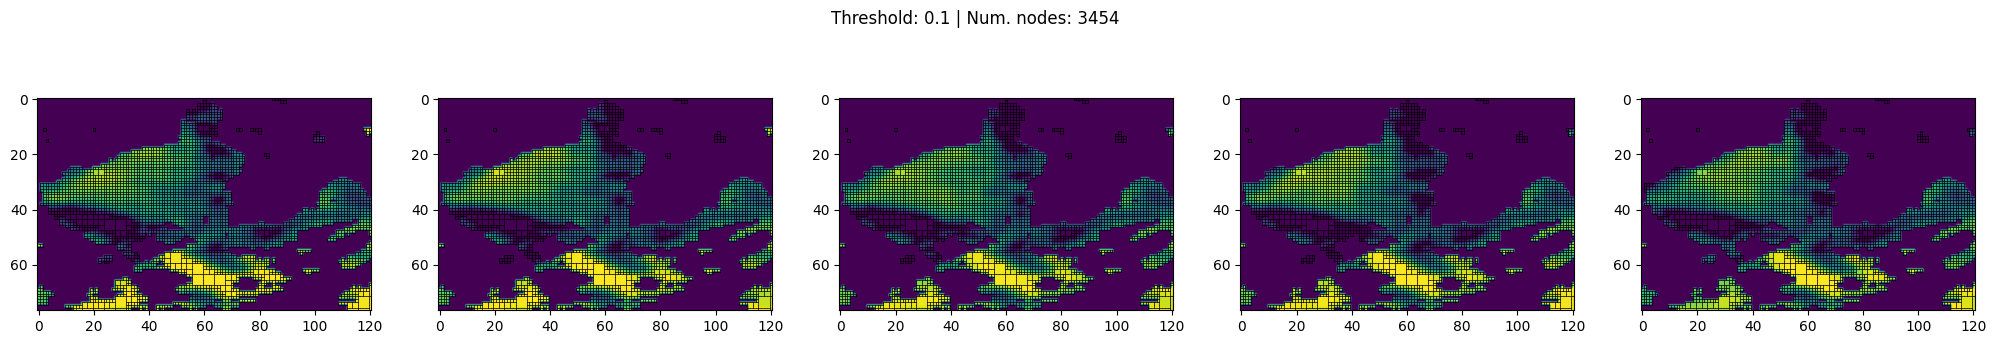

In [49]:
frame_index = 0

fig, axs = model.test_threshold(x_viz, thresh=-2, mask=mask, contours=False)
plt.show()

for t in [0.5, 0.4, 0.3, 0.2, 0.1]:
    fig, axs = model.test_threshold(x_viz, thresh=t, mask=mask)
    plt.show()
    

In [1]:
torch.manual_seed(1)

model.model.train()
model.train(loader_train, loader_test, lr=0.01, n_epochs=10, mask=mask)  # Train for 20 epochs


# model.model.eval()
# model.score(x_val, y_val[:, :1])  # Check the MSE on the validation set

NameError: name 'torch' is not defined

<Axes: >

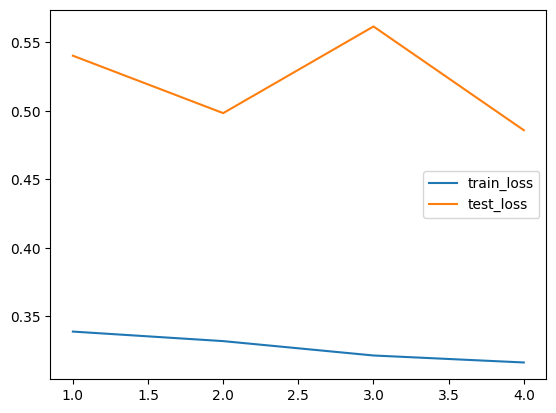

In [20]:
model.loss.iloc[1:].plot()
model.loss.to_csv('ice_results/loss.csv')

In [25]:
model.save('test_results')

In [11]:
# Get predictions on the validation set
model.model.eval()
y_hat = model.predict(loader_val, mask)

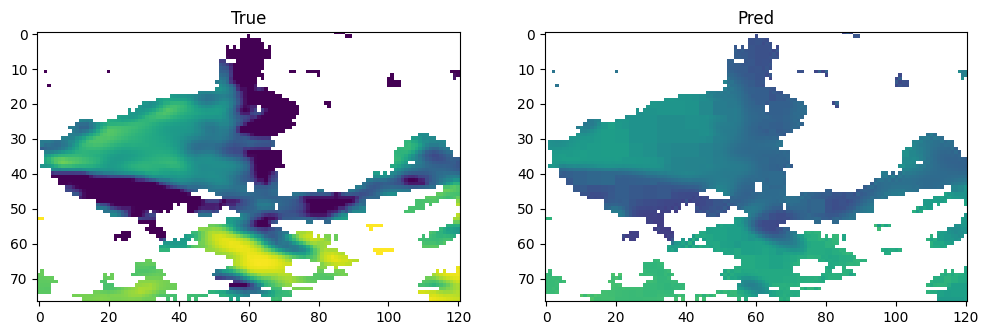

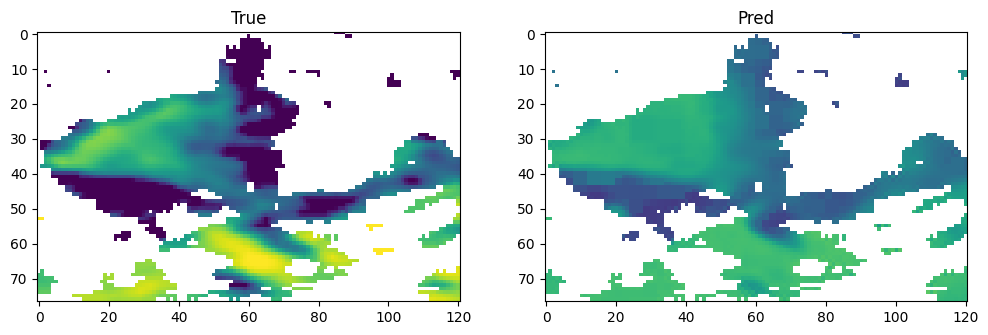

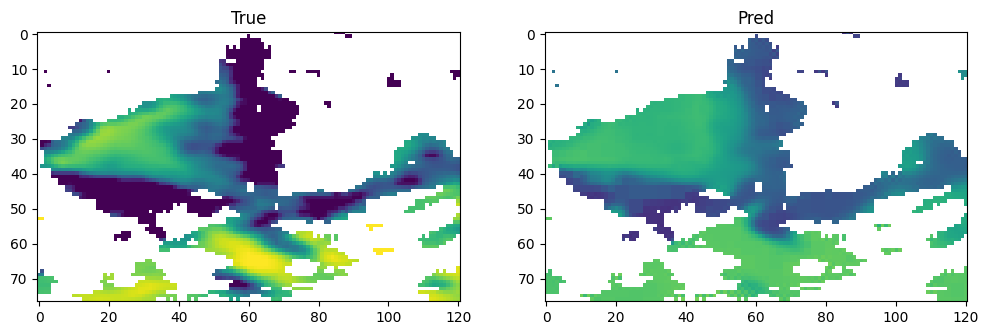

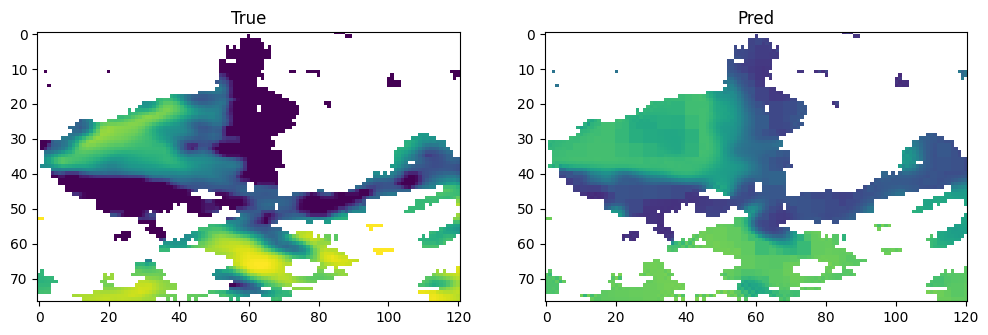

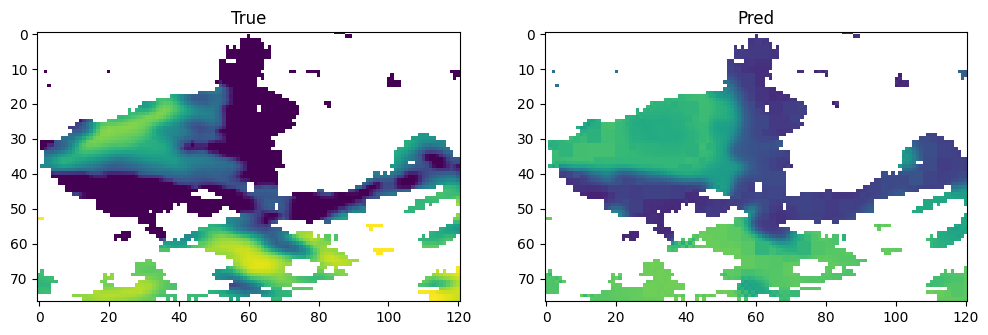

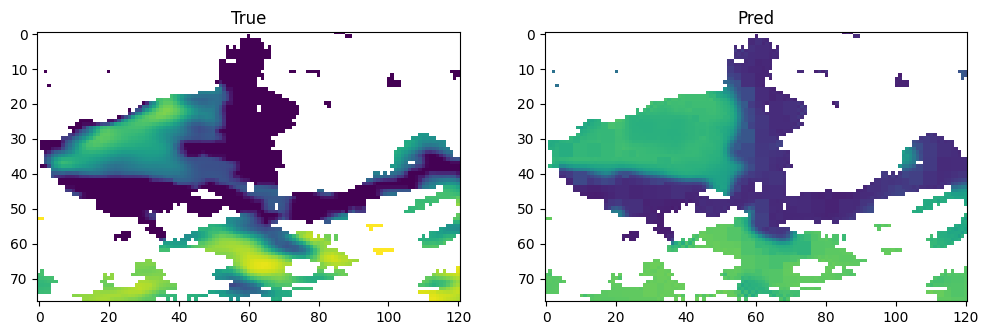

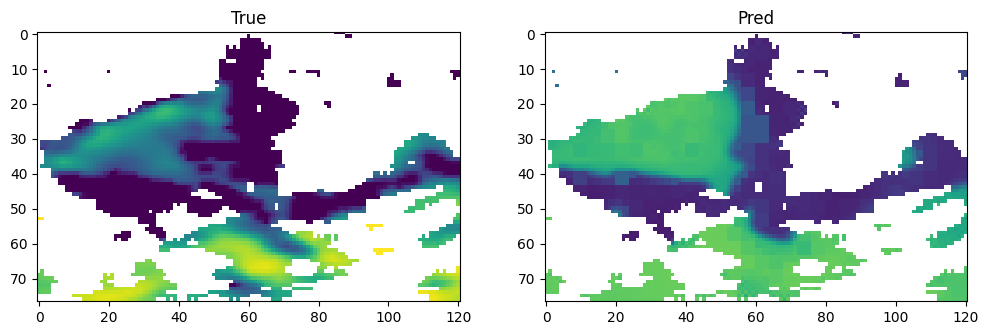

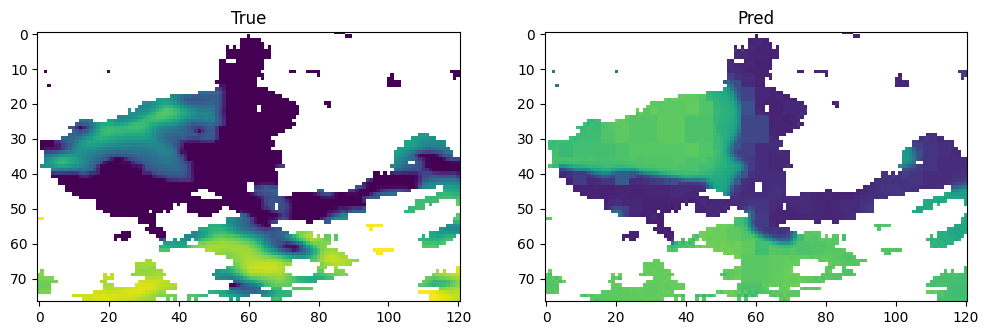

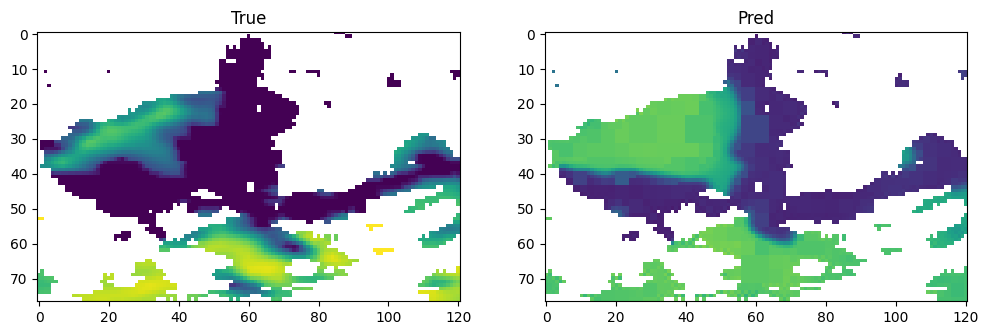

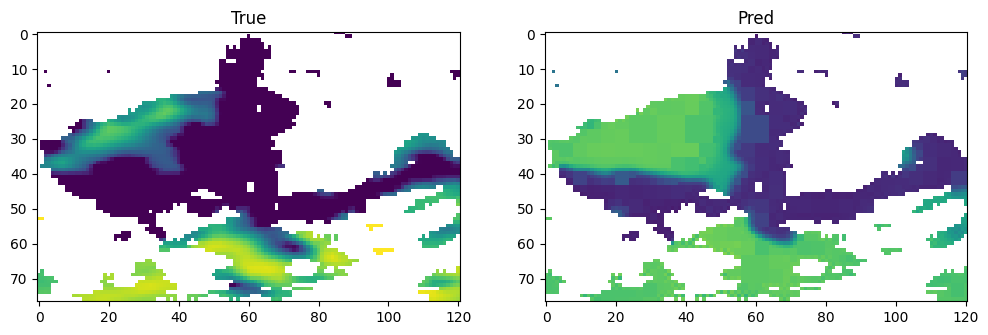

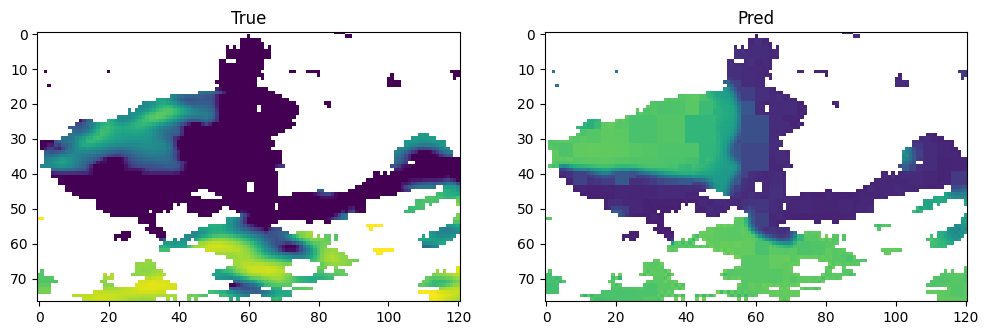

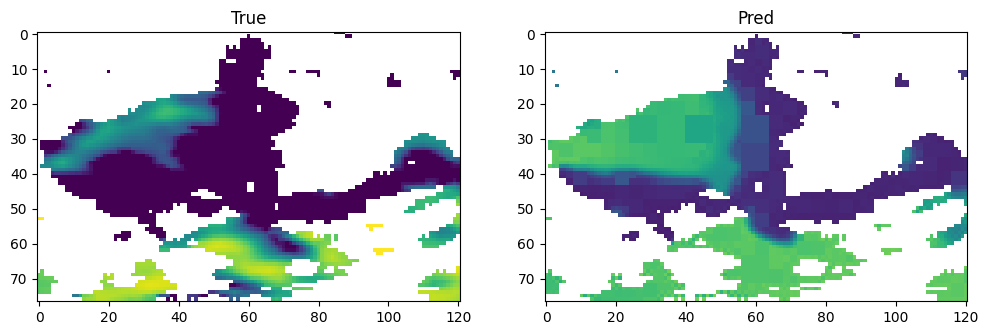

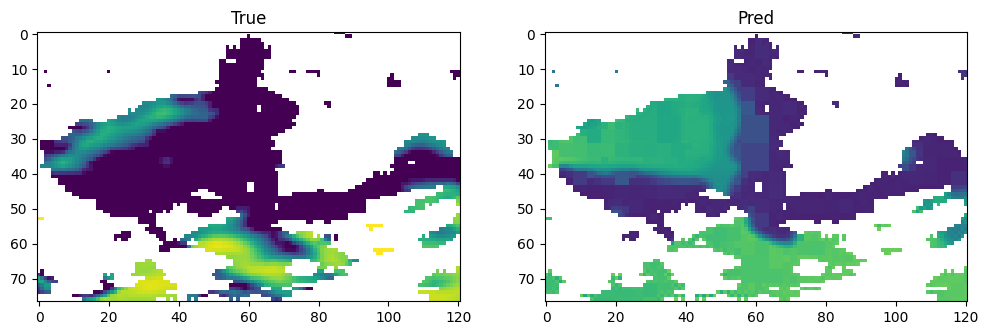

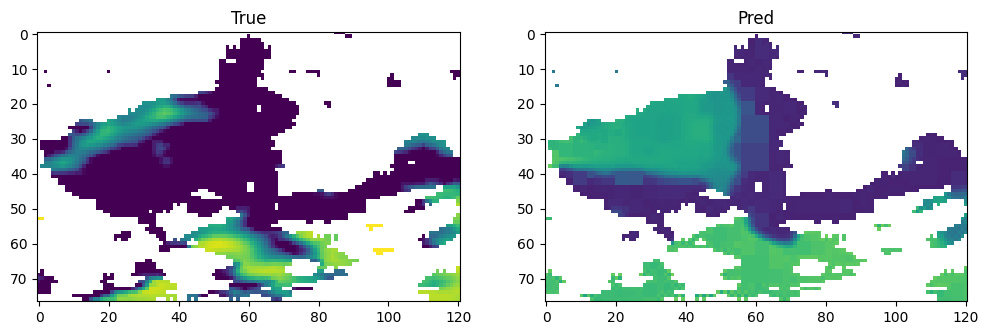

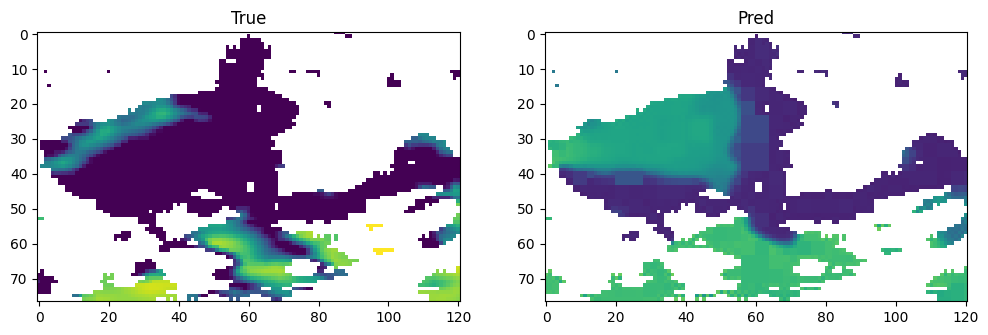

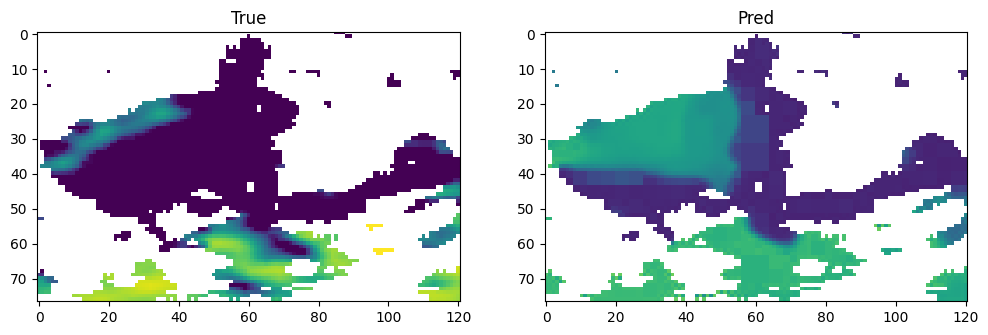

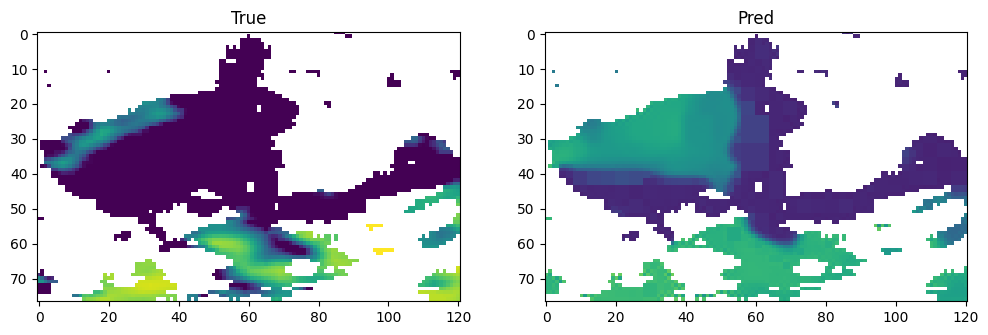

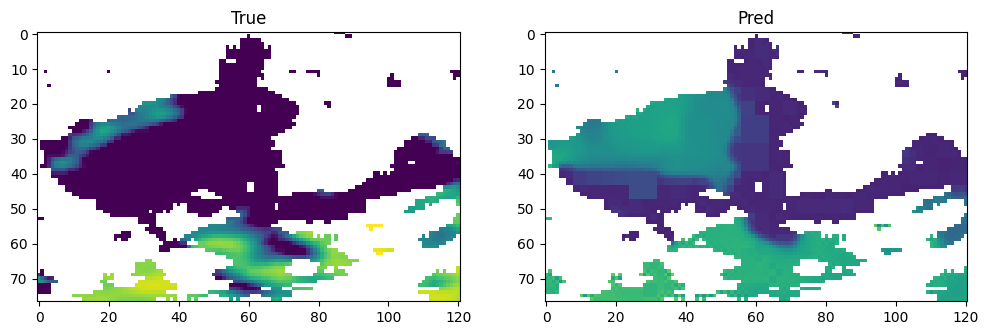

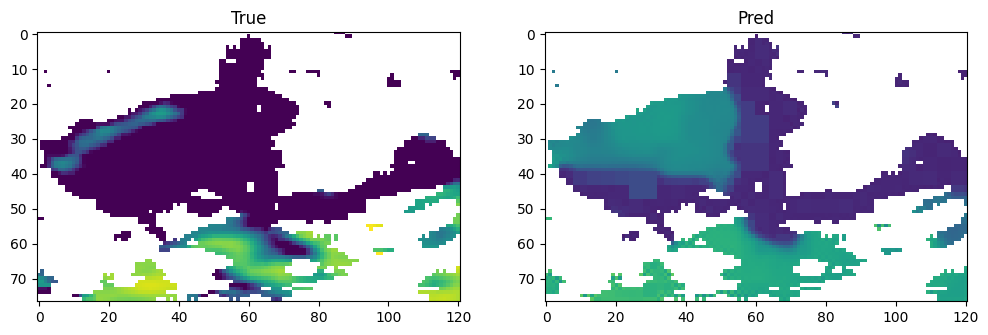

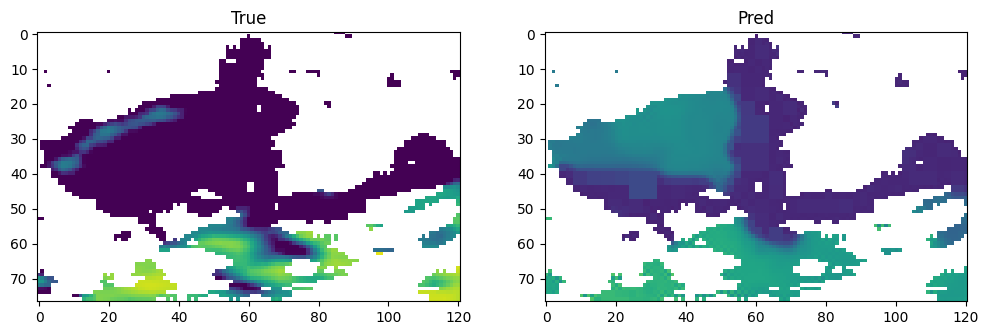

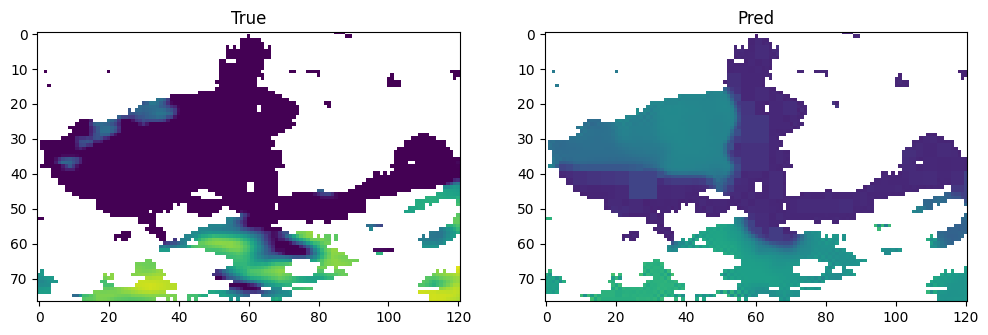

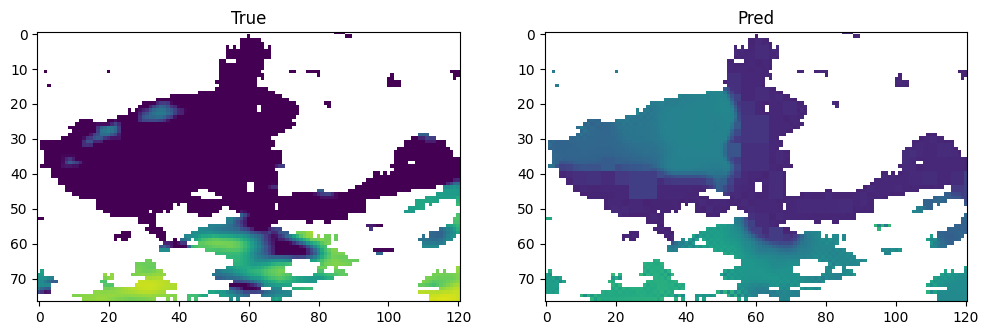

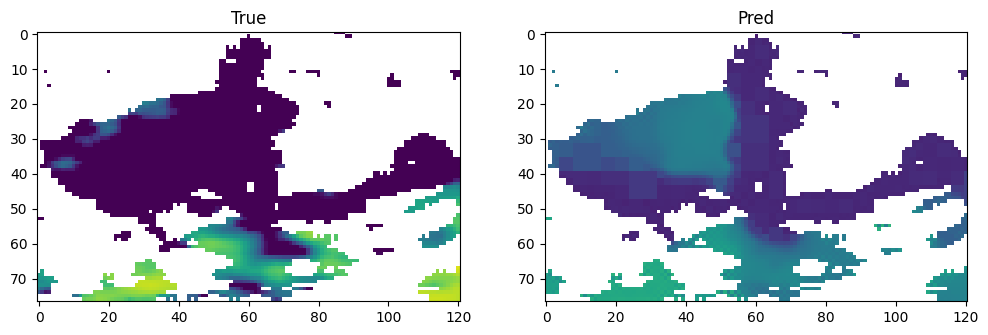

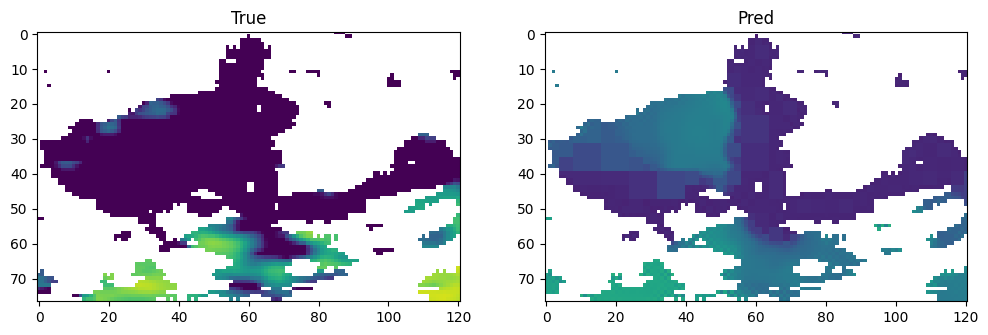

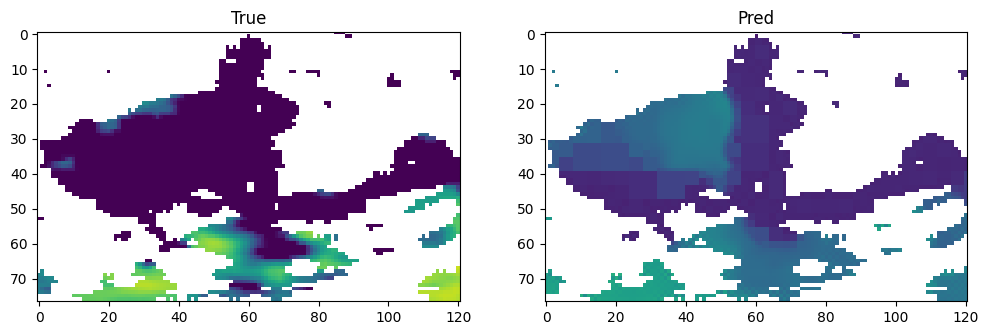

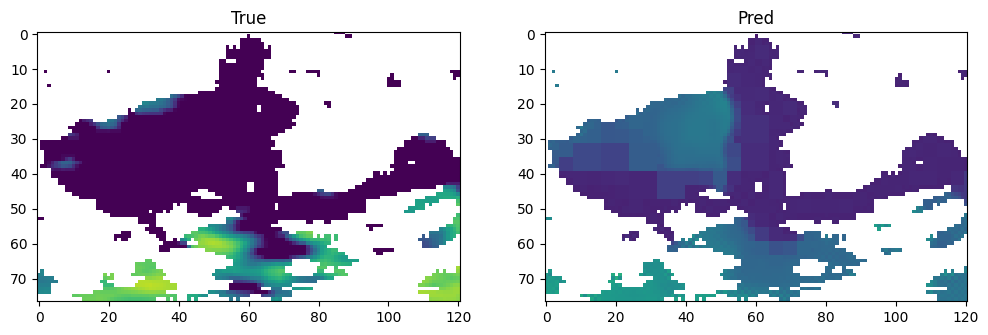

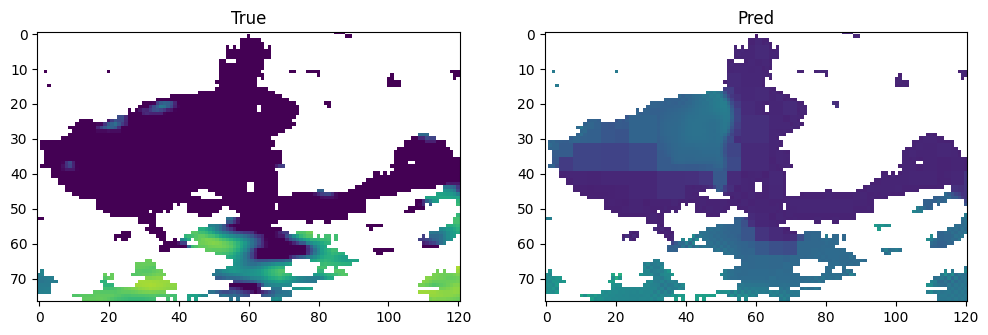

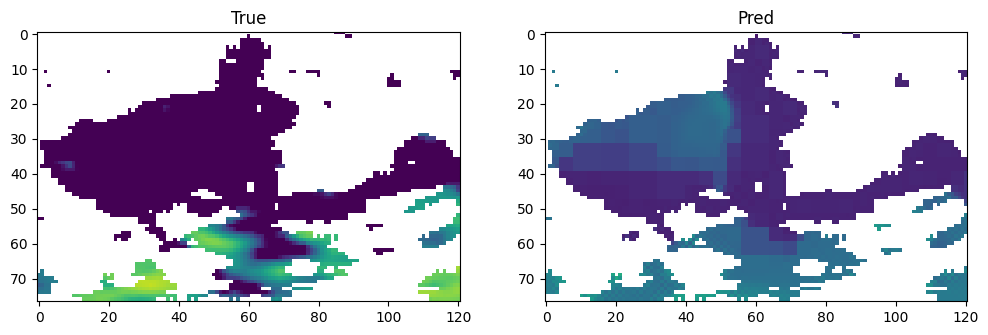

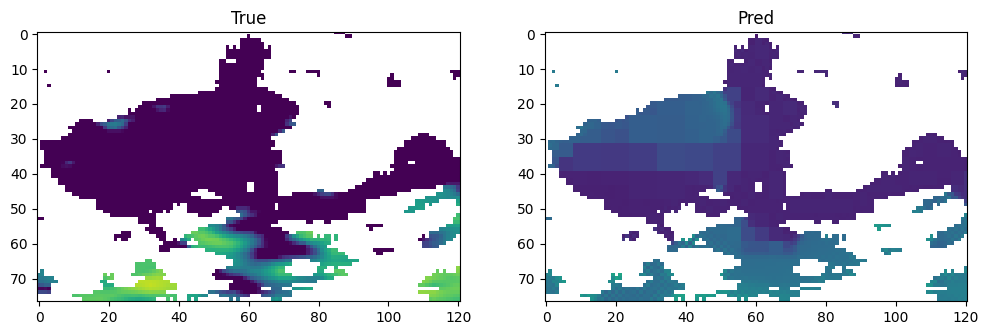

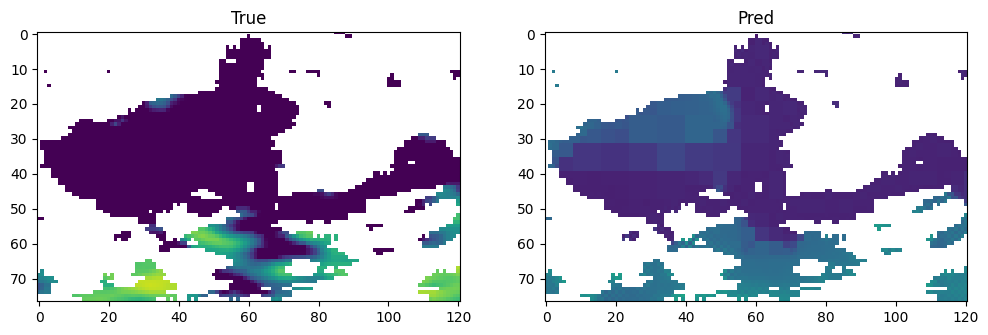

In [12]:
launch_step = 15

y_val = loader_val.dataset.y

for i in range(output_timesteps):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    y_val_step = y_val[launch_step][i].squeeze(-1)
    y_hat_step = y_hat[launch_step][i].squeeze(-1)
    
    axs[0].imshow(np.where(~mask, y_val_step, np.nan), vmin=0, vmax=1)
    axs[1].imshow(np.where(~mask, y_hat_step, np.nan), vmin=0, vmax=1)
    axs[0].set_title('True')
    axs[1].set_title('Pred')
    plt.show()

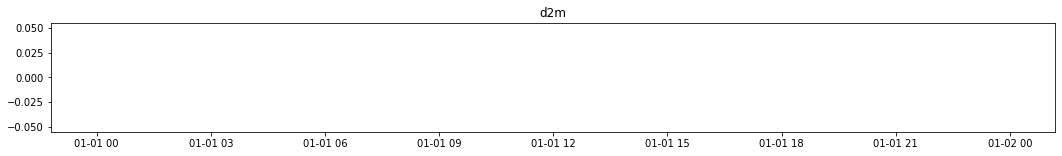

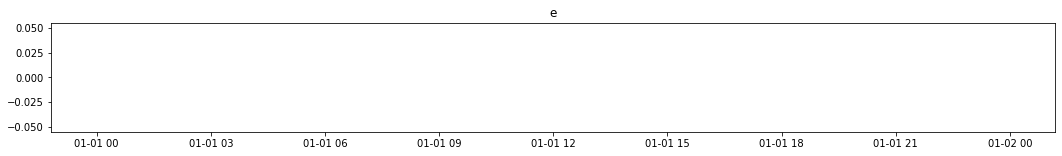

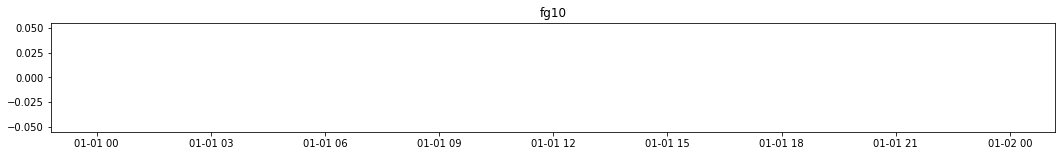

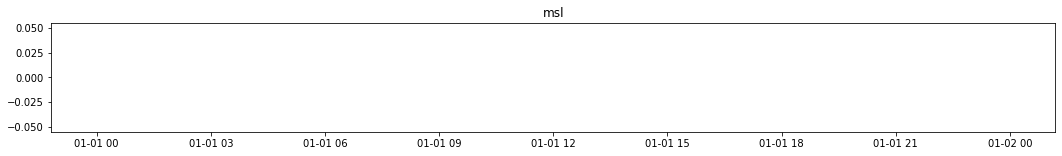

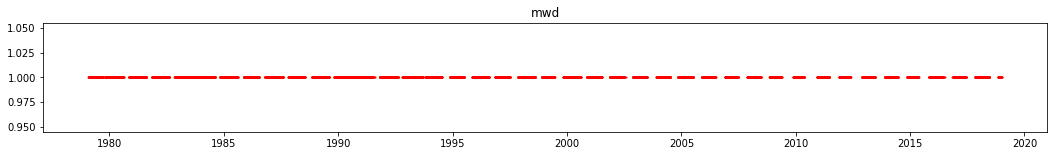

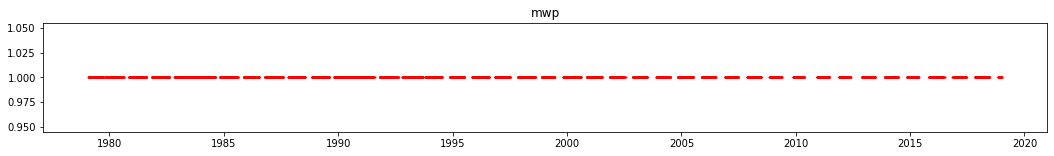

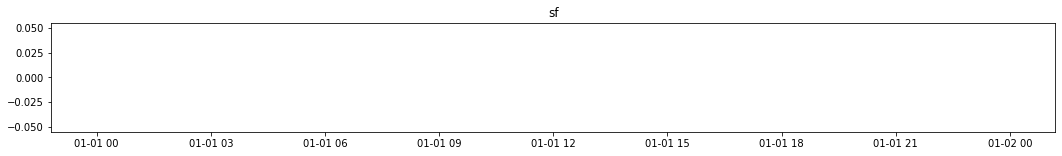

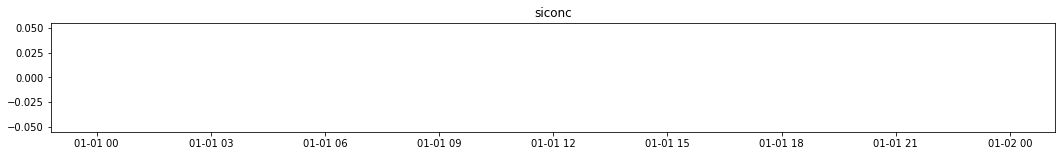

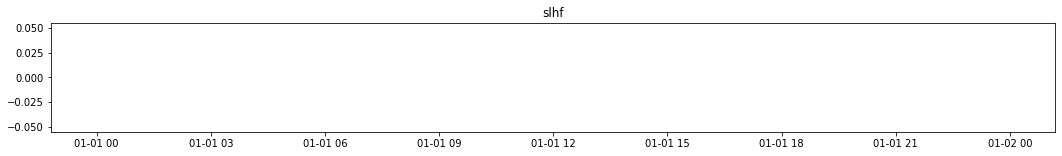

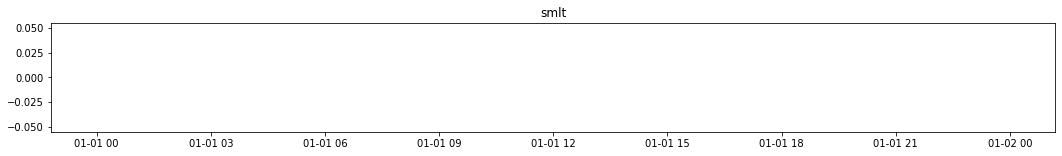

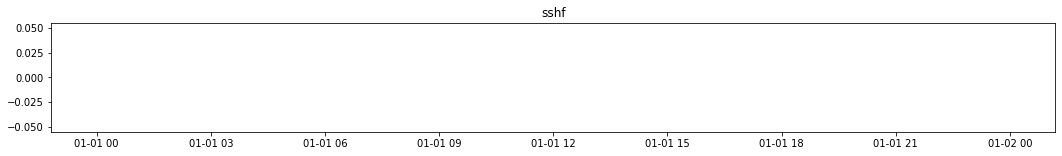

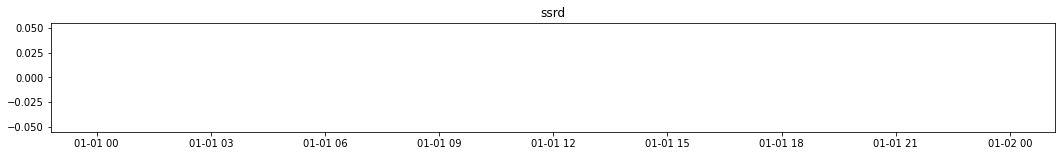

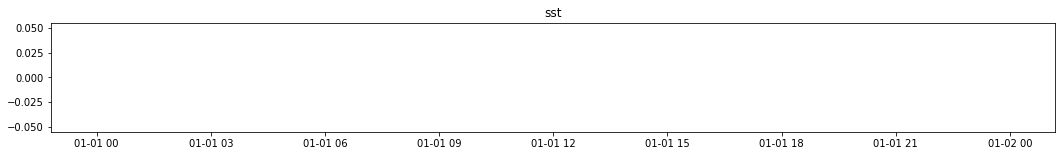

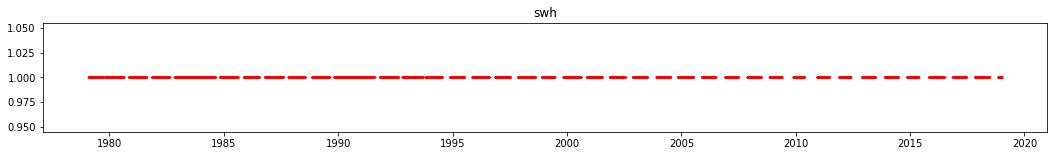

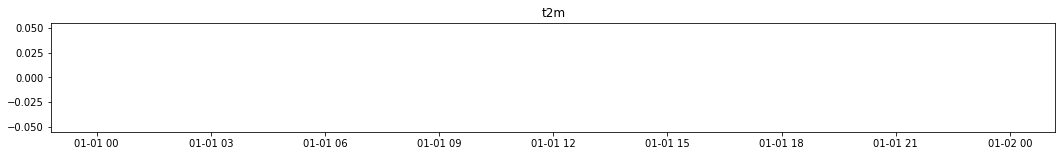

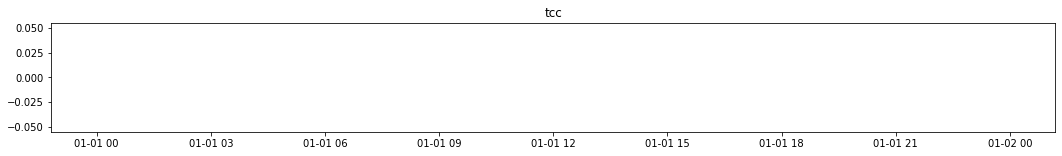

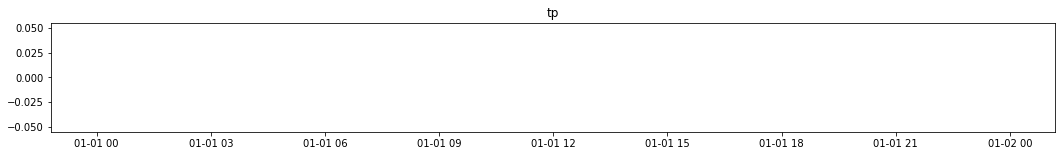

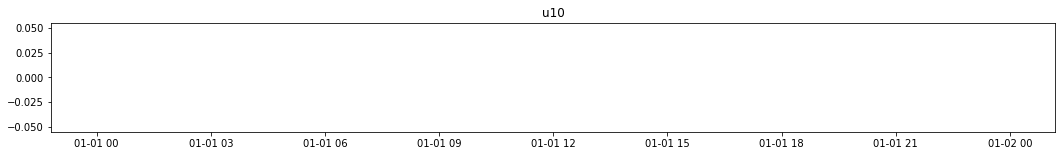

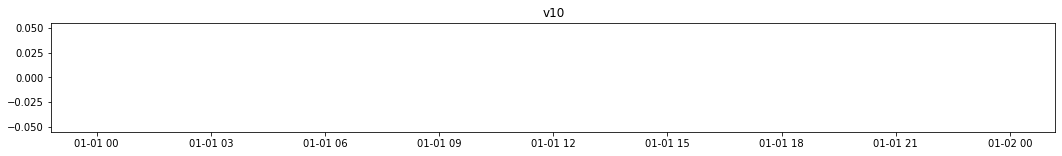

In [42]:
for d in ds.data_vars:
    plt.figure(figsize=(18, 2))
    plt.scatter(ds.time, np.where(np.isnan(ds.isel(latitude=50, longitude=50)[d]), 1, np.nan), c='r', s=1)
    plt.title(d)
    plt.show()

### Meshing test

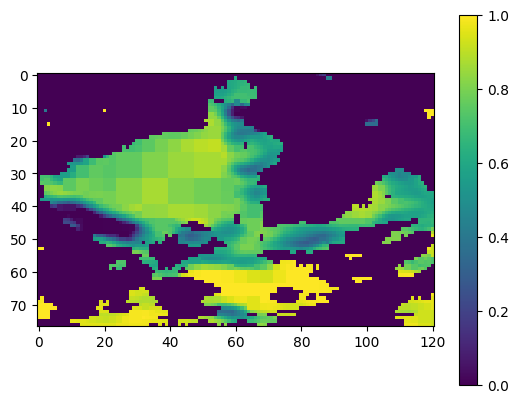

In [8]:
from utils import add_positional_encoding
from graph_functions import image_to_graph, unflatten

x, _ = next(iter(loader_val))
x = x.squeeze(0)

thresh=0.35

n_sample, w, h, c = x.shape
image_shape = (w, h)

x_with_pos_encoding = add_positional_encoding(x)

graph = image_to_graph(x_with_pos_encoding, thresh=thresh, mask=mask, transform_func=lambda arr: abs(abs(arr - 0.5) - 0.5))
img_reconstructed = unflatten(graph['data'][..., [0]], graph['mapping'], image_shape)

num_nodes = len(np.unique(graph['labels']))

plt.imshow(img_reconstructed[0, ..., 0])
plt.colorbar()